In [1]:
import os
os.chdir('/workspace') # change to the root directory of the project

import numpy as np
import pandas as pd
import joblib
import gc

from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression, ElasticNet, Lasso, Ridge
from sklearn.metrics import r2_score, mean_squared_error, mean_poisson_deviance, roc_curve, roc_auc_score, jaccard_score

from utils import model_metrics_rms

import matplotlib.pyplot as plt
import seaborn as sns
sns.set_theme(style="darkgrid")

In [2]:
path = "data/MALDI_IHC/correlations/"
path_results = f"{path}results/"
path_models = f"{path_results}models/"

# Load the data

In [ ]:
# Load the normalized MSI data
peaks = pd.read_pickle(f"{path}peaks_standardized_lesion.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered_lesion.pkl")

peaks.shape, pixels.shape

# Remove the unwanted sildes

In [4]:
# list of unwanted slides
bad_lames = ['13AG03225-06', '13AG06573-10', '544085-14', '546332-17', '549724-18', '549724-19', '549764-29', '549857-19', '549857-22', '552138-25']

# Remove the bad samples
peaks = peaks[~pixels['run'].isin(bad_lames)]
pixels = pixels[~pixels['run'].isin(bad_lames)]

# Define the densities and a threshold for each pixel density

In [5]:
# Determine the densities of the selected pixels
densities = ["Density_CD8", "Density_Tumor", "Density_Stroma", "Density_Collagen"]

# Get the number of lames and densities
lames = pixels['run'].unique()
n_lames = len(lames)

# Define the threshold for each density
threshold = {
    'Density_CD8': 0.03,
    'Density_Tumor': 0.1,
    'Density_Stroma': 0.8,
    'Density_Collagen': 0.5
    }

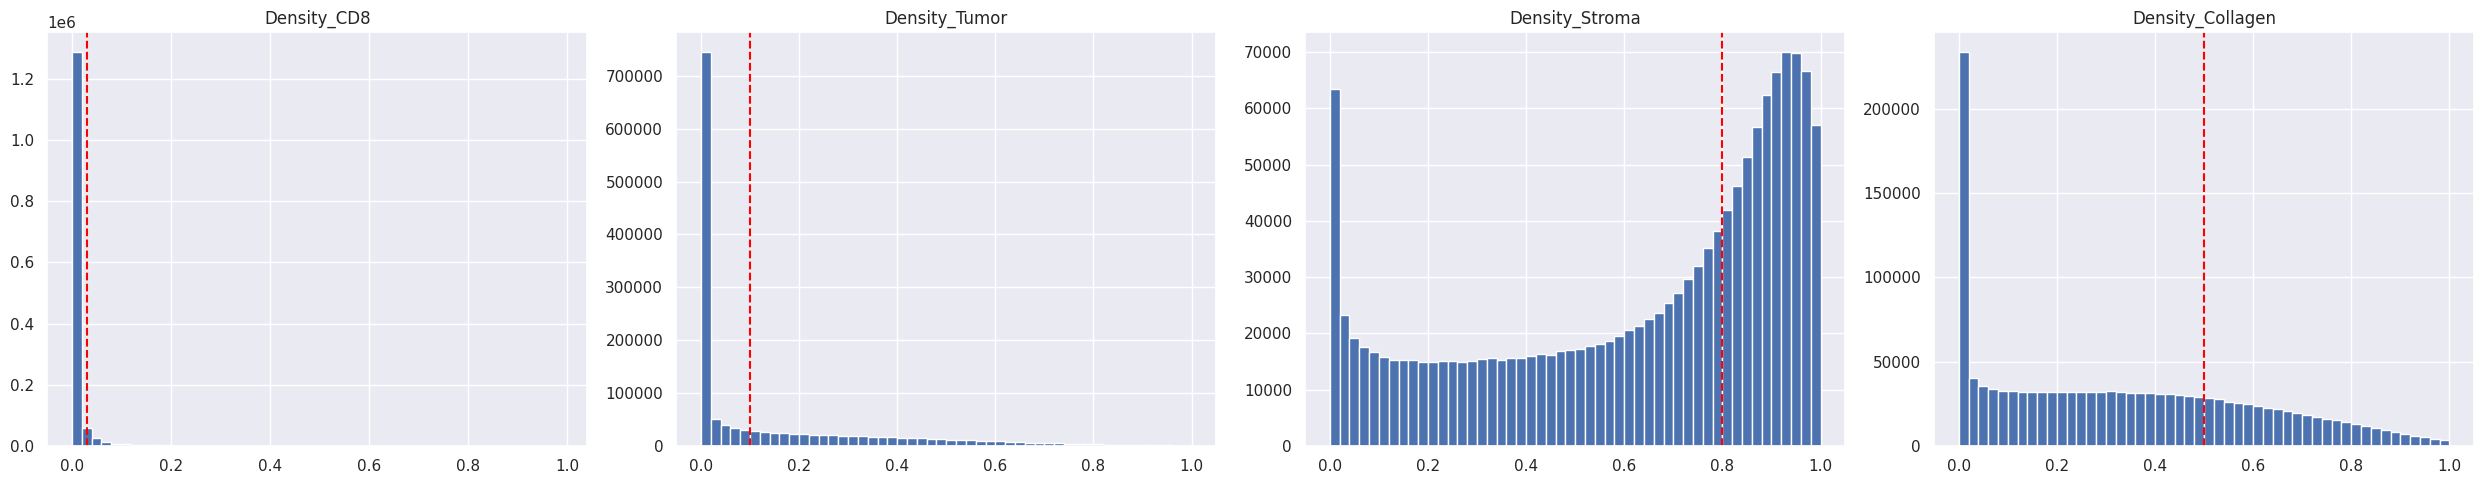

In [6]:
# Plot a histogram of the densities
fig, axes = plt.subplots(1, 4, figsize=(25, 5), tight_layout=True)
for i, (ax, density) in enumerate(zip(axes, densities)):
    ax.hist(pixels[density], bins=50)
    ax.axvline(threshold[density], color='red', linestyle='--')
    ax.set_title(density)
    # ax.set_yscale('log')
plt.show()

# Clean the Defective pixels

In [7]:
# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# Exclude the tumors pixels
peaks = peaks[pixels["Density_Tumor"] < 0.1]
pixels = pixels[pixels["Density_Tumor"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

# Split the data into training and testing sets

In [8]:
# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(peaks[pixels["Density_Lesion"] > 0.5].values,
                                                    pixels[pixels["Density_Lesion"] > 0.5]['Density_CD8'].values,
                                                    test_size=0.05,
                                                    random_state=42)

# Transform the target variable

In [9]:
# Take the root mean square of the densities
y_train_rms = np.sqrt(y_train)
y_test_rms = np.sqrt(y_test)

# Perform a linear regression

In [10]:
# Create a sample weights for the model
pixels_weight = 1 + 2 * y_train

In [11]:
# Create a linear regression model
model_reg = LinearRegression()

# Train the model
model_reg.fit(X=X_train, y=y_train_rms, sample_weight=pixels_weight)

LinearRegression()

R-squared (Train): 0.13
R-squared (Test): 0.13
Mean Squared Error (Train): 6.79e-04
Mean Squared Error (Test): 6.64e-04
Deviance (Train): 3.04e-02
Deviance (Test): 3.02e-02


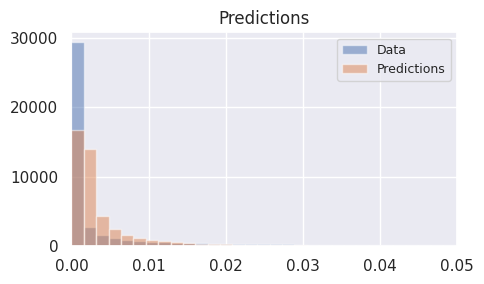

In [12]:
# perform the prediction
_ = model_metrics_rms(model_reg, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

R-squared (Train): 0.13
R-squared (Test): 0.14
Mean Squared Error (Train): 6.94e-04
Mean Squared Error (Test): 6.79e-04
Deviance (Train): 3.18e-02
Deviance (Test): 3.16e-02


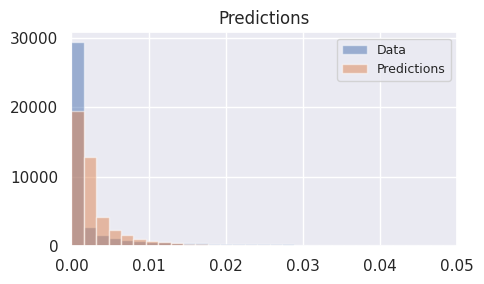

In [11]:
# perform the prediction
_ = model_metrics_rms(model_reg, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

# Transform the target variable

In [13]:
# Compute the area of the pixels
MALDI_PIXEL_LENGTH = 50  # Pixel length of the MALDI images
IMAGE_PIXEL_LENGTH = 0.2631  # Pixel length of the images in micrometers
l = int((MALDI_PIXEL_LENGTH / IMAGE_PIXEL_LENGTH) / 2)
AREA = (2*l)**2  # Area of the pixels in square micrometers

# Transform the target to pixel counts instead of density
y_train_cts = (y_train * AREA).astype(int)
y_test_cts = (y_test * AREA).astype(int)

# log transform the target
y_train_cts_log = np.log1p(y_train_cts)
y_test_cts_log = np.log1p(y_test_cts)

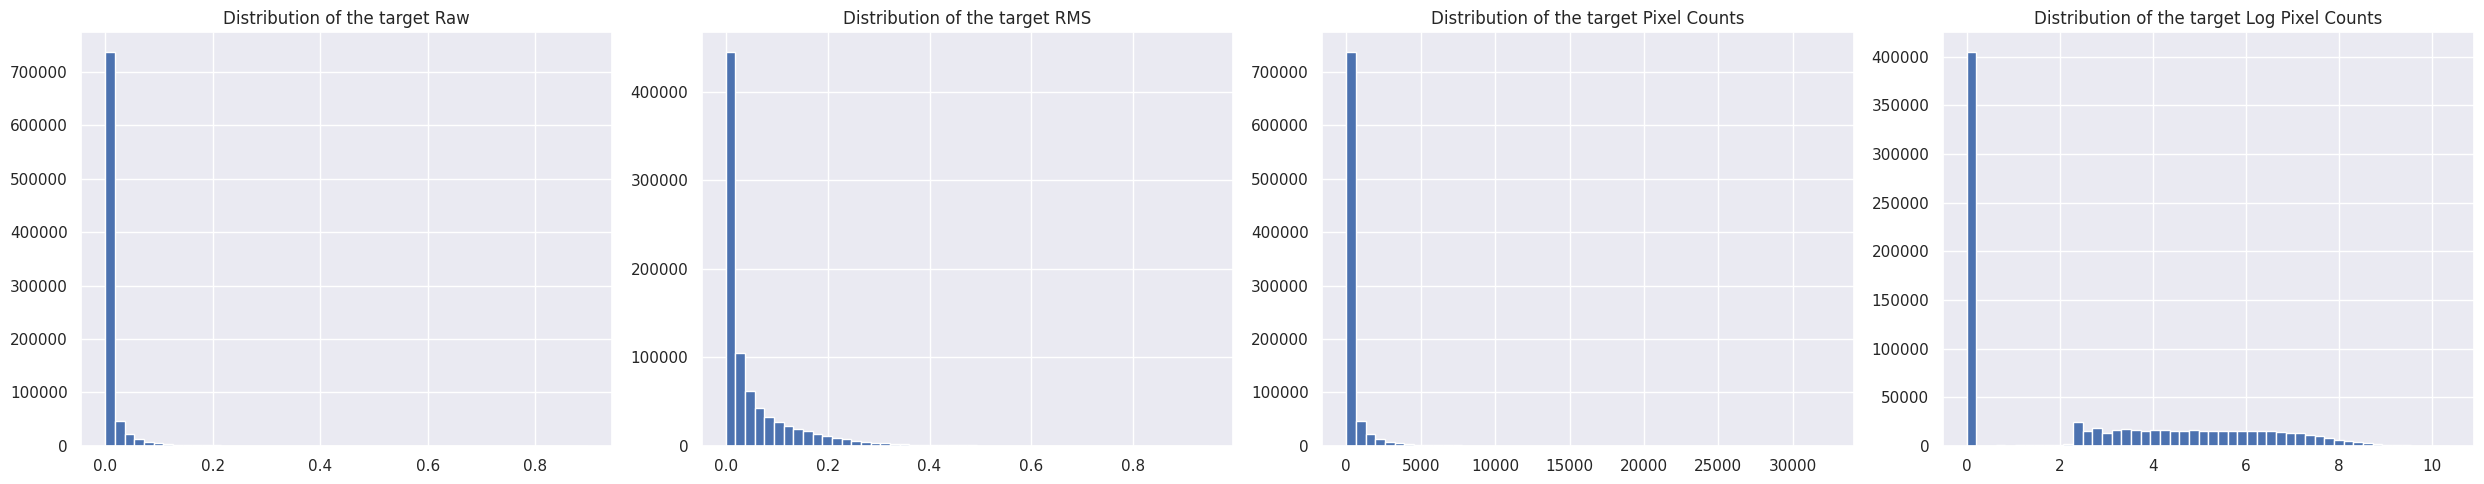

In [14]:
# Plot the distribution of the target
fig, axes = plt.subplots(1, 4, figsize=(25, 5), tight_layout=True)
for i, (name, density) in enumerate(zip(['Raw', 'RMS', 'Pixel Counts', 'Log Pixel Counts'], [y_train, y_train_rms, y_train_cts, y_train_cts_log])):
    axes[i].hist(density, bins=50)
    axes[i].set_title(f"Distribution of the target {name}")
    # ax.set_yscale('log')
plt.show()

In [15]:
# Train the model on the pixel counts instead of the density
model_reg_cts = LinearRegression()
model_reg_cts.fit(X=X_train, y=y_train_cts, sample_weight=pixels_weight)

LinearRegression()

R-squared (Train): 0.09
R-squared (Test): 0.10
Mean Squared Error (Train): 6.56e-04
Mean Squared Error (Test): 6.41e-04
Deviance (Train): 2.72e-02
Deviance (Test): 2.73e-02


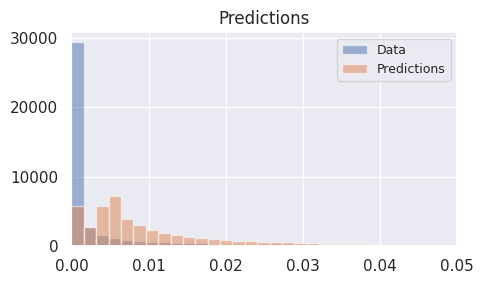

In [16]:
# Make predictions
y_pred_train = model_reg_cts.predict(X_train)
y_pred_test = model_reg_cts.predict(X_test)

# Transform the predictions to density
y_pred_train = y_pred_train / AREA
y_pred_test = y_pred_test / AREA

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# Clip the negative values
y_pred_train = np.clip(a=y_pred_train, a_min=0.000001, a_max=1)
y_pred_test = np.clip(a=y_pred_test, a_min=0.000001, a_max=1)

# Compute the deviance
deviance_train = mean_poisson_deviance(y_train, y_pred_train)
deviance_test = mean_poisson_deviance(y_test, y_pred_test)

print(f"Deviance (Train): {deviance_train:.2e}")
print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 500)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
# ax.set_yscale('log')
ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

R-squared (Train): 0.04
R-squared (Test): 0.03
Mean Squared Error (Train): 4.83e-04
Mean Squared Error (Test): 4.67e-04
Deviance (Train): 2.37e-02
Deviance (Test): 2.35e-02


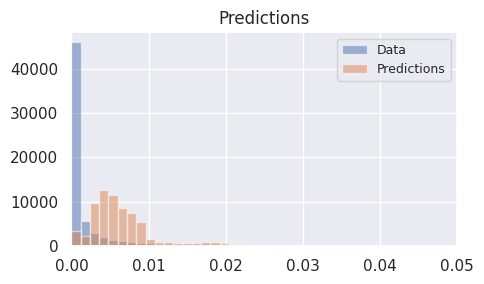

In [15]:
# Make predictions
y_pred_train = model_reg_cts.predict(X_train)
y_pred_test = model_reg_cts.predict(X_test)

# Transform the predictions to density
y_pred_train = y_pred_train / AREA
y_pred_test = y_pred_test / AREA

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# Clip the negative values
y_pred_train = np.clip(a=y_pred_train, a_min=0.000001, a_max=1)
y_pred_test = np.clip(a=y_pred_test, a_min=0.000001, a_max=1)

# Compute the deviance
deviance_train = mean_poisson_deviance(y_train, y_pred_train)
deviance_test = mean_poisson_deviance(y_test, y_pred_test)

print(f"Deviance (Train): {deviance_train:.2e}")
print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 500)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
# ax.set_yscale('log')
ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

In [ ]:
# Train the model on the pixel counts instead of the density
model_reg_cts_log = LinearRegression()
model_reg_cts_log.fit(X=X_train, y=y_train_cts_log, sample_weight=1+2*y_train)

LinearRegression()

R-squared (Train): 0.10
R-squared (Test): 0.10
Mean Squared Error (Train): 7.08e+00
Mean Squared Error (Test): 7.06e+00


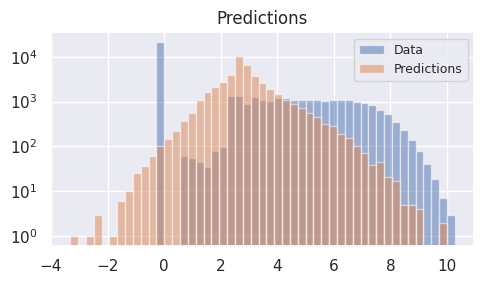

In [22]:
# Make predictions
y_pred_train_log = model_reg_cts_log.predict(X_train)
y_pred_test_log = model_reg_cts_log.predict(X_test)

# # Transform the predictions to density
# y_pred_train_log = np.expm1(y_pred_train_log) / AREA
# y_pred_test_log = np.expm1(y_pred_test_log) / AREA

# Compute R-squared
r2_train = r2_score(y_train_cts_log, y_pred_train_log)
r2_test = r2_score(y_test_cts_log, y_pred_test_log)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train_cts_log, y_pred_train_log)
mse_test = mean_squared_error(y_test_cts_log, y_pred_test_log)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# # Clip the negative values
# y_pred_train = np.clip(a=y_pred_train, a_min=0.000001, a_max=1)
# y_pred_test = np.clip(a=y_pred_test, a_min=0.000001, a_max=1)

# # Compute the deviance
# deviance_train = mean_poisson_deviance(y_train, y_pred_train)
# deviance_test = mean_poisson_deviance(y_test, y_pred_test)

# print(f"Deviance (Train): {deviance_train:.2e}")
# print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test_cts_log.min(), y_pred_test_log.min()), max(y_test_cts_log.max(), y_pred_test_log.max()), 50)
ax.hist(y_test_cts_log, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test_log, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

R-squared (Train): 0.02
R-squared (Test): 0.02
Mean Squared Error (Train): 6.59e+00
Mean Squared Error (Test): 6.55e+00


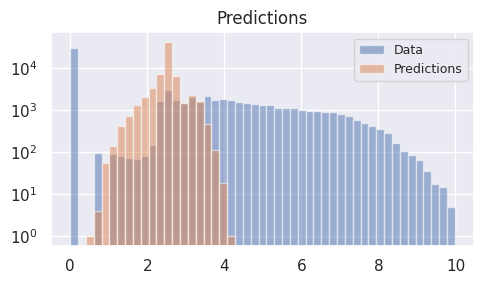

In [17]:
# Make predictions
y_pred_train_log = model_reg_cts_log.predict(X_train)
y_pred_test_log = model_reg_cts_log.predict(X_test)

# # Transform the predictions to density
# y_pred_train_log = np.expm1(y_pred_train_log) / AREA
# y_pred_test_log = np.expm1(y_pred_test_log) / AREA

# Compute R-squared
r2_train = r2_score(y_train_cts_log, y_pred_train_log)
r2_test = r2_score(y_test_cts_log, y_pred_test_log)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train_cts_log, y_pred_train_log)
mse_test = mean_squared_error(y_test_cts_log, y_pred_test_log)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# # Clip the negative values
# y_pred_train = np.clip(a=y_pred_train, a_min=0.000001, a_max=1)
# y_pred_test = np.clip(a=y_pred_test, a_min=0.000001, a_max=1)

# # Compute the deviance
# deviance_train = mean_poisson_deviance(y_train, y_pred_train)
# deviance_test = mean_poisson_deviance(y_test, y_pred_test)

# print(f"Deviance (Train): {deviance_train:.2e}")
# print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test_cts_log.min(), y_pred_test_log.min()), max(y_test_cts_log.max(), y_pred_test_log.max()), 50)
ax.hist(y_test_cts_log, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test_log, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
ax.set_yscale('log')
# ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

R-squared (Train): 0.04
R-squared (Test): 0.04
Mean Squared Error (Train): 4.82e-04
Mean Squared Error (Test): 4.66e-04
Deviance (Train): 2.37e-02
Deviance (Test): 2.35e-02


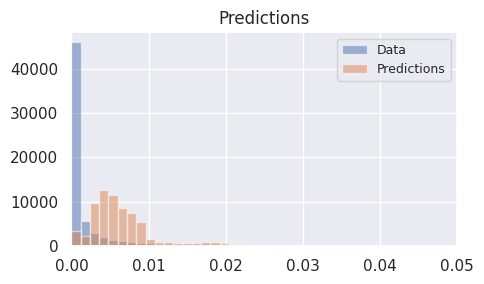

In [18]:
# Make predictions
y_pred_train_log = model_reg_cts_log.predict(X_train)
y_pred_test_log = model_reg_cts_log.predict(X_test)

# Transform the predictions to density
y_pred_train_log = np.expm1(y_pred_train_log) / AREA
y_pred_test_log = np.expm1(y_pred_test_log) / AREA

# Compute R-squared
r2_train = r2_score(y_train, y_pred_train)
r2_test = r2_score(y_test, y_pred_test)

print(f"R-squared (Train): {r2_train:.2f}")
print(f"R-squared (Test): {r2_test:.2f}")

# Compute the mean squared error
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print(f"Mean Squared Error (Train): {mse_train:.2e}")
print(f"Mean Squared Error (Test): {mse_test:.2e}")

# Clip the negative values
y_pred_train = np.clip(a=y_pred_train, a_min=0.000001, a_max=1)
y_pred_test = np.clip(a=y_pred_test, a_min=0.000001, a_max=1)

# Compute the deviance
deviance_train = mean_poisson_deviance(y_train, y_pred_train)
deviance_test = mean_poisson_deviance(y_test, y_pred_test)

print(f"Deviance (Train): {deviance_train:.2e}")
print(f"Deviance (Test): {deviance_test:.2e}")

# Plot a histogram of the predictions
fig, ax = plt.subplots(1, 1, figsize=(5, 3), tight_layout=True)
bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 500)
ax.hist(y_test, bins=bins, alpha=0.5, label='Data')
ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
ax.set_title('Predictions')
# ax.set_yscale('log')
ax.set_xlim(0, 0.05)
ax.legend(fontsize=9)
plt.show()

In [23]:
# Create a laso regression model
model_lasso = Lasso(alpha=0.001, max_iter=10**6, tol=1e-6)

# Train the model
model_lasso.fit(X_train, y_train_rms, sample_weight=pixels_weight)

Lasso(alpha=0.001, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.27
R-squared (Test): 0.27
Mean Squared Error (Train): 6.25e-04
Mean Squared Error (Test): 6.08e-04
Deviance (Train): 2.36e-02
Deviance (Test): 2.32e-02


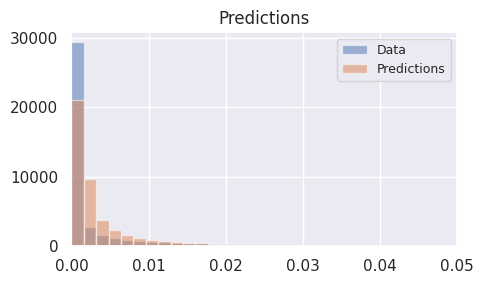

In [24]:
# perform the prediction
_ = model_metrics_rms(model_lasso, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

R-squared (Train): 0.26
R-squared (Test): 0.26
Mean Squared Error (Train): 6.47e-04
Mean Squared Error (Test): 6.30e-04
Deviance (Train): 2.50e-02
Deviance (Test): 2.47e-02


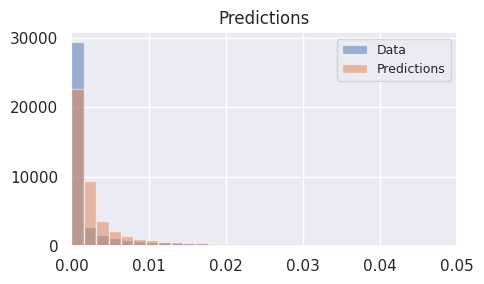

In [ ]:
# perform the prediction
_ = model_metrics_rms(model_lasso, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [25]:
# Create a ridge regression model
model_ridge = Ridge(alpha=0.01, max_iter=10**6, tol=1e-6)

# Train the model
model_ridge.fit(X_train, y_train_rms, sample_weight=pixels_weight)

/home/vscode/.local/lib/python3.12/site-packages/sklearn/linear_model/_ridge.py:215: LinAlgWarning: Ill-conditioned matrix (rcond=1.61694e-09): result may not be accurate.
  return linalg.solve(A, Xy, assume_a="pos", overwrite_a=True).T


Ridge(alpha=0.01, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.33
R-squared (Test): 0.32
Mean Squared Error (Train): 5.68e-04
Mean Squared Error (Test): 5.60e-04
Deviance (Train): 2.05e-02
Deviance (Test): 2.05e-02


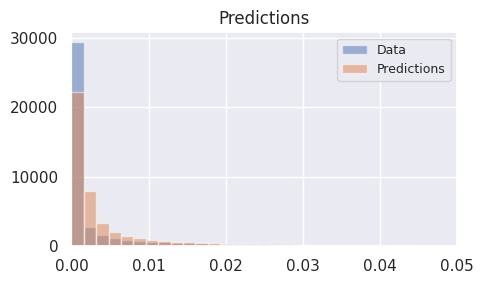

In [26]:
_ = model_metrics_rms(model_ridge, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

R-squared (Train): 0.33
R-squared (Test): 0.32
Mean Squared Error (Train): 5.87e-04
Mean Squared Error (Test): 5.77e-04
Deviance (Train): 2.14e-02
Deviance (Test): 2.13e-02


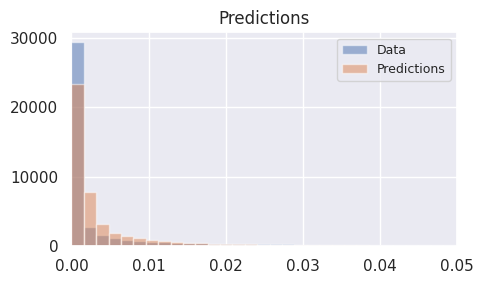

In [ ]:
_ = model_metrics_rms(model_ridge, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [27]:
# Create a elastic net regression model
model_en = ElasticNet(alpha=0.001, l1_ratio=0.5, max_iter=10**6, tol=1e-6)

# Train the model
model_en.fit(X_train, y_train_rms, sample_weight=pixels_weight)

ElasticNet(alpha=0.001, max_iter=1000000, tol=1e-06)

R-squared (Train): 0.29
R-squared (Test): 0.29
Mean Squared Error (Train): 6.07e-04
Mean Squared Error (Test): 5.90e-04
Deviance (Train): 2.24e-02
Deviance (Test): 2.21e-02


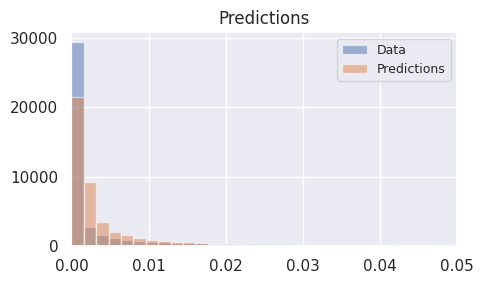

In [28]:
_ = model_metrics_rms(model_en, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

R-squared (Train): 0.29
R-squared (Test): 0.29
Mean Squared Error (Train): 6.28e-04
Mean Squared Error (Test): 6.12e-04
Deviance (Train): 2.37e-02
Deviance (Test): 2.34e-02


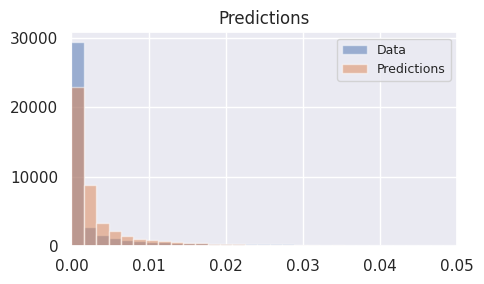

In [ ]:
_ = model_metrics_rms(model_en, X_train, y_train, X_test, y_test, y_train_rms, y_test_rms)

In [29]:
# Initialize the values
r2_train_list, r2_test_list, mse_train_list, mse_test_list, deviance_train_list, deviance_test_list = [], [], [], [], [], []

# Create a table with the results
for model, name in zip([model_reg, model_lasso, model_ridge, model_en],
                       ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
    
    # Perform the prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute R-squared
    r2_train_list.append(r2_score(y_train_rms, y_pred_train))
    r2_test_list.append(r2_score(y_test_rms, y_pred_test))

    # Square the predictions
    y_pred_train = y_pred_train ** 2
    y_pred_test = y_pred_test ** 2

    # Clip the negative values
    y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
    y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)

    # Compute the mean squared error
    mse_train_list.append(mean_squared_error(y_train, y_pred_train))
    mse_test_list.append(mean_squared_error(y_test, y_pred_test))

    # Compute the deviance
    deviance_train_list.append(mean_poisson_deviance(y_train, y_pred_train))
    deviance_test_list.append(mean_poisson_deviance(y_test, y_pred_test))

# Create a DataFrame with the results
results = pd.DataFrame({'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net'],
                        'R-squared (train)': r2_train_list,
                        'R-squared (test)': r2_test_list,
                        'Mean Squared Error (train)': mse_train_list,
                        'Mean Squared Error (test)': mse_test_list,
                        'Deviance (train)': deviance_train_list,
                        'Deviance (test)': deviance_test_list})
results

,Model,R-squared (train),R-squared (test),Mean Squared Error (train),Mean Squared Error (test),Deviance (train),Deviance (test)
0,Linear Regression,0.128863,0.133776,0.000679,0.000664,0.030381,0.030159
1,Lasso Regression,0.265947,0.270988,0.000625,0.000608,0.023571,0.023241
2,Ridge Regression,0.325499,0.319743,0.000568,0.000560,0.020482,0.020478
3,Elastic Net,0.289861,0.293893,0.000607,0.000590,0.022394,0.022094


In [25]:
# Initialize the values
r2_train_list, r2_test_list, mse_train_list, mse_test_list, deviance_train_list, deviance_test_list = [], [], [], [], [], []

# Create a table with the results
for model, name in zip([model_reg, model_lasso, model_ridge, model_en],
                       ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
    
    # Perform the prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute R-squared
    r2_train_list.append(r2_score(y_train_rms, y_pred_train))
    r2_test_list.append(r2_score(y_test_rms, y_pred_test))

    # Square the predictions
    y_pred_train = y_pred_train ** 2
    y_pred_test = y_pred_test ** 2

    # Clip the negative values
    y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
    y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)

    # Compute the mean squared error
    mse_train_list.append(mean_squared_error(y_train, y_pred_train))
    mse_test_list.append(mean_squared_error(y_test, y_pred_test))

    # Compute the deviance
    deviance_train_list.append(mean_poisson_deviance(y_train, y_pred_train))
    deviance_test_list.append(mean_poisson_deviance(y_test, y_pred_test))

# Create a DataFrame with the results
results = pd.DataFrame({'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net'],
                        'R-squared (train)': r2_train_list,
                        'R-squared (test)': r2_test_list,
                        'Mean Squared Error (train)': mse_train_list,
                        'Mean Squared Error (test)': mse_test_list,
                        'Deviance (train)': deviance_train_list,
                        'Deviance (test)': deviance_test_list})
results

,Model,R-squared (train),R-squared (test),Mean Squared Error (train),Mean Squared Error (test),Deviance (train),Deviance (test)
0,Linear Regression,0.131344,0.135732,0.000694,0.000679,0.031798,0.031587
1,Lasso Regression,0.259897,0.264348,0.000647,0.000630,0.025025,0.024684
2,Ridge Regression,0.329405,0.324626,0.000587,0.000577,0.021423,0.021343
3,Elastic Net,0.285440,0.289018,0.000628,0.000612,0.023700,0.023412


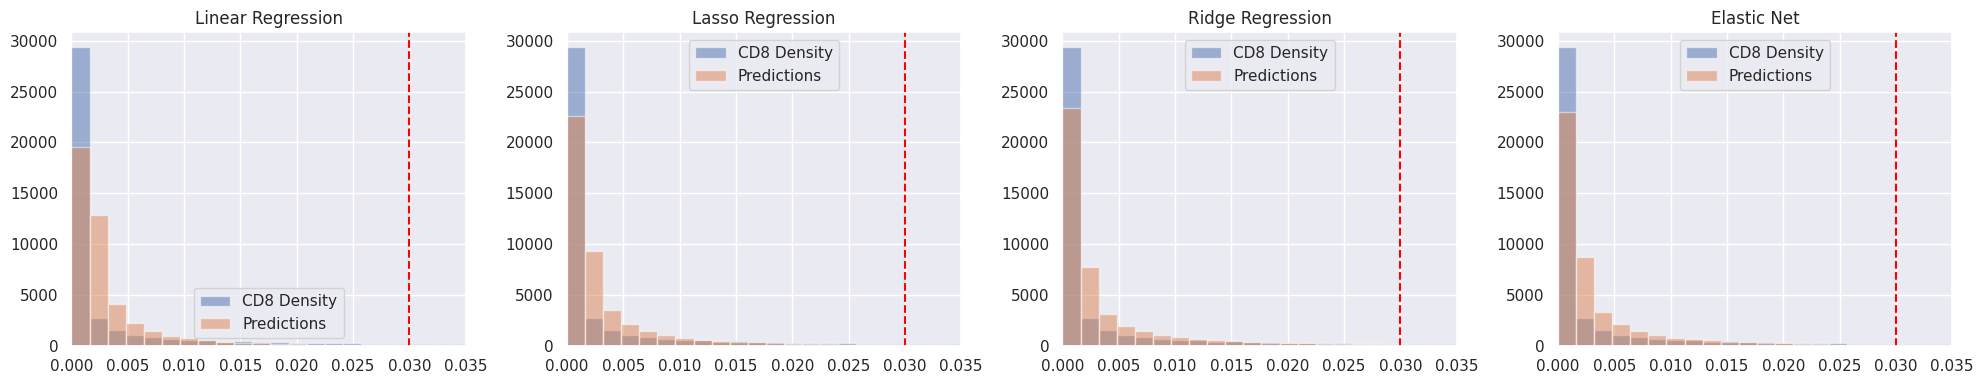

In [26]:
# Plot a histogram of the predictions for all models
fig, axes = plt.subplots(1, 4, figsize=(20, 4), tight_layout=True)

for ax, model, name in zip(axes,
                           [model_reg, model_lasso, model_ridge, model_en],
                           ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
     y_pred_train = model.predict(X_train)
     y_pred_test = model.predict(X_test)
    
     # Square the predictions
     y_pred_train = y_pred_train ** 2
     y_pred_test = y_pred_test ** 2
    
     # Clip the negative values
     y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
     y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)
    
     bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 500)
     ax.hist(y_test, bins=bins, alpha=0.5, label='CD8 Density')
     ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
     ax.axvline(threshold['Density_CD8'], color='red', linestyle='--')
     ax.set_title(name)
     # ax.set_yscale('log')
     ax.set_xlim(0, 0.035)
     ax.legend()
plt.show()

In [19]:
# Initialize the values
r2_train_list, r2_test_list, mse_train_list, mse_test_list, deviance_train_list, deviance_test_list = [], [], [], [], [], []

# Create a table with the results
for model, name in zip([model_reg, model_lasso, model_ridge, model_en],
                       ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
    
    # Perform the prediction
    y_pred_train = model.predict(X_train)
    y_pred_test = model.predict(X_test)

    # Compute R-squared
    r2_train_list.append(r2_score(y_train_rms, y_pred_train))
    r2_test_list.append(r2_score(y_test_rms, y_pred_test))

    # Square the predictions
    y_pred_train = y_pred_train ** 2
    y_pred_test = y_pred_test ** 2

    # Clip the negative values
    y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
    y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)

    # Compute the mean squared error
    mse_train_list.append(mean_squared_error(y_train, y_pred_train))
    mse_test_list.append(mean_squared_error(y_test, y_pred_test))

    # Compute the deviance
    deviance_train_list.append(mean_poisson_deviance(y_train, y_pred_train))
    deviance_test_list.append(mean_poisson_deviance(y_test, y_pred_test))

# Create a DataFrame with the results
results = pd.DataFrame({'Model': ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net'],
                        'R-squared (train)': r2_train_list,
                        'R-squared (test)': r2_test_list,
                        'Mean Squared Error (train)': mse_train_list,
                        'Mean Squared Error (test)': mse_test_list,
                        'Deviance (train)': deviance_train_list,
                        'Deviance (test)': deviance_test_list})
results

,Model,R-squared (train),R-squared (test),Mean Squared Error (train),Mean Squared Error (test),Deviance (train),Deviance (test)
0,Linear Regression,0.026529,0.026410,0.000446,0.000435,0.026059,0.025691
1,Lasso Regression,0.169899,0.168880,0.000416,0.000406,0.020346,0.020145
2,Ridge Regression,0.239811,0.232252,0.000383,0.000377,0.017408,0.017407
3,Elastic Net,0.192831,0.191684,0.000407,0.000397,0.019416,0.019258


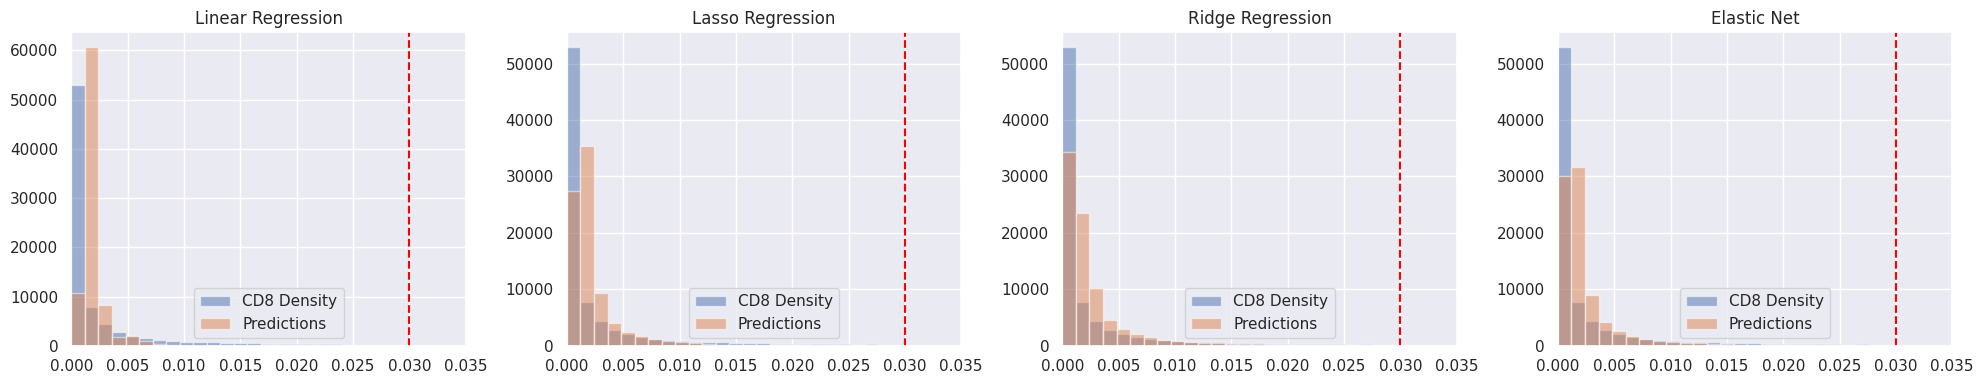

In [20]:
# Plot a histogram of the predictions for all models
fig, axes = plt.subplots(1, 4, figsize=(20, 4), tight_layout=True)

for ax, model, name in zip(axes,
                           [model_reg, model_lasso, model_ridge, model_en],
                           ['Linear Regression', 'Lasso Regression', 'Ridge Regression', 'Elastic Net']):
     y_pred_train = model.predict(X_train)
     y_pred_test = model.predict(X_test)
    
     # Square the predictions
     y_pred_train = y_pred_train ** 2
     y_pred_test = y_pred_test ** 2
    
     # Clip the negative values
     y_pred_train = np.clip(a=y_pred_train, a_min=0, a_max=1)
     y_pred_test = np.clip(a=y_pred_test, a_min=0, a_max=1)
    
     bins = np.linspace(min(y_test.min(), y_pred_test.min()), max(y_test.max(), y_pred_test.max()), 500)
     ax.hist(y_test, bins=bins, alpha=0.5, label='CD8 Density')
     ax.hist(y_pred_test, bins=bins, alpha=0.5, label='Predictions')
     ax.axvline(threshold['Density_CD8'], color='red', linestyle='--')
     ax.set_title(name)
     # ax.set_yscale('log')
     ax.set_xlim(0, 0.035)
     ax.legend()
plt.show()

# Save the models

In [30]:
# save the models
joblib.dump(model_reg, f"{path_models}model_reg_weighted_without_tumor.joblib")
joblib.dump(model_lasso, f"{path_models}model_lasso_weighted_without_tumor.joblib")
joblib.dump(model_ridge, f"{path_models}model_ridge_weighted_without_tumor.joblib")
joblib.dump(model_en, f"{path_models}model_en_weighted_without_tumor.joblib")

['data/MALDI_IHC/correlations/results/models/model_en_weighted_without_tumor.joblib']

In [7]:
# load the models
model_reg = joblib.load(f"{path_models}model_reg_weighted_without_tumor.joblib")
model_lasso = joblib.load(f"{path_models}model_lasso_weighted_without_tumor.joblib")
model_ridge = joblib.load(f"{path_models}model_ridge_weighted_without_tumor.joblib")
model_en = joblib.load(f"{path_models}model_en_weighted_without_tumor.joblib")

In [3]:
# Reload the peaks and pixels data
peaks = pd.read_pickle(f"{path}peaks_standardized.pkl")
pixels = pd.read_pickle(f"{path}pixels_filtered.pkl")

# Exclude the pixels with defects
peaks = peaks[pixels["Density_Defects"] < 0.1]
pixels = pixels[pixels["Density_Defects"] < 0.1]

# # Exclude the tumors pixels
# peaks = peaks[pixels["Density_Tumor"] < 0.1]
# pixels = pixels[pixels["Density_Tumor"] < 0.1]

# Reset the index
peaks.reset_index(drop=True, inplace=True)
pixels.reset_index(drop=True, inplace=True)

In [4]:
# list of unwanted slides
bad_lames = ['13AG03225-06', '13AG06573-10', '544085-14', '546332-17', '549724-18', '549724-19', '549764-29', '549857-19', '549857-22', '552138-25']

# Remove the bad samples
peaks = peaks[~pixels['run'].isin(bad_lames)]
pixels = pixels[~pixels['run'].isin(bad_lames)]

In [8]:
# Apply the weights to all the peaks
pixels['Reg_CD8'] = np.clip(a=model_reg.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_Lasso_CD8'] = np.clip(a=model_lasso.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_Ridge_CD8'] = np.clip(a=model_ridge.predict(peaks.values) ** 2, a_min=0, a_max=1)
pixels['Reg_ElasticNet_CD8'] = np.clip(a=model_en.predict(peaks.values) ** 2, a_min=0, a_max=1)

In [9]:
predictions = ['Density_CD8', 'Reg_CD8', 'Reg_Ridge_CD8', 'Reg_Lasso_CD8', 'Reg_ElasticNet_CD8']

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=len(predictions), figsize=(50, 200), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels[pixels['run'] == lame]
    for j, prediction in enumerate(predictions):
        # Create a pivot table for imshow
        heatmap_data = pixels_lame.pivot(index='y', columns='x', values=prediction)
        
        # Display the heatmap
        im = axs[i, j].imshow(heatmap_data, cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99), origin='upper')
        fig.colorbar(im, ax=axs[i, j])
        
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.savefig(f"{path_results}predictions_CD8_weighted_without_tumor.png")
plt.close()

# Plot the predicted CD8 density for each lame compared to the original CD8 density
fig, axs = plt.subplots(nrows=n_lames, ncols=len(predictions), figsize=(50, 200), tight_layout=True)

for i, lame in enumerate(lames):
    pixels_lame = pixels[pixels['run'] == lame]
    pixels_lame = pixels_lame[pixels_lame['Density_Lesion'] > 0.5]
    for j, prediction in enumerate(predictions):
        # Create a pivot table for imshow
        heatmap_data = pixels_lame.pivot(index='y', columns='x', values=prediction)
        
        # Display the heatmap
        im = axs[i, j].imshow(heatmap_data, cmap='viridis', vmin=0, vmax=np.quantile(pixels_lame[prediction], 0.99), origin='upper')
        fig.colorbar(im, ax=axs[i, j])
        
        if i == 0: axs[i, j].set_title(prediction)
        if j == 0: axs[i, j].set_ylabel(lame)
        axs[i, j].set_xticks([])
        axs[i, j].set_yticks([])

plt.savefig(f"{path_results}predictions_CD8_lesion_weighted_without_tumor.png")
plt.close()